### CRITERI DI RICERCA:
- analisi delle persone sopravvissute
- analisi delle persone non sopravvissute
- analisi delle variabili
- analizzare le parti più sicure della nave in base alla classe in cui si è
    1. la nave è andata giù di prua
    2. la parte più sicura per un periodo è stata la poppa
    3. una volta spaccata a metà, la prua è affondata subito, la poppa poco dopo
    4. la prima classe era in alto, la seconda verso la poppa al centro, la terza era a prua e a poppa in basso
- selezionare quale variabile è la più incisiva a nostro parere
- dare un peso diverso ad ogni colonna e aggregare i risultati

### SUDDIVISIONE LAVORO:
- chi analizza i sopravvissuti/non sopravvissuti
- chi analizza le variabili
- chi analizza la situazione della nave

# RISOLUZIONE DEL PROBLEMA

Come prima cosa, abbiamo importato le librerie necessarie al corretto funzionamento del programma.

Successivamente abbiamo importato i due file conteneti i dati dei passeggeri. I file non sono stati importati integramente, in quanto abbiamo ritenuto che alcune colonne, come ad esempio il nome, il numero del biglietto e ..., non fossero utili alla risoluzione.

In [237]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb # data visualization
import matplotlib.pyplot as plt # data visualization
from sklearn.ensemble import RandomForestClassifier as rfc # algorithm
from sklearn.metrics import accuracy_score # algotithm
from sklearn.model_selection import train_test_split

In [238]:
relevant_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
train = pd.read_csv('train.csv', usecols = relevant_cols + ['Survived'])
test = pd.read_csv('test.csv', usecols = relevant_cols + ['PassengerId'])

I dati importati sono stati manipolati affinchè potessero essere utilizzati pù facilmente nell'elaborazione:
- i valori della colonna "Sex" sono stati trasformati rispettivamente da "male, female" a "0, 1";
- i valori nulli della colonna "Age" sono stati sostituiti con la media dei valori presenti nella stessa colonna;
- i valori della colonna "Age" sono stati trasformati da float in intero.

In [239]:
train.replace(['male','female'],[0,1], inplace=True)
train['Age'] = train['Age'].fillna(train['Age'].mean())
train['Age'] = train['Age'].astype(int)
train['Fare'] = train['Fare'].astype(int)

test.replace(['male','female'],[0,1], inplace=True)
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Age'] = test['Age'].astype(int)
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test['Fare'] = test['Fare'].astype(int)

Una volta completata la parte di pre-processing, abbiamo osservato la struttura del DataFrame di addestramento per capire quali tipi di elaborazioni avremmo potuto fare.

In [240]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int32
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int32
dtypes: int32(2), int64(5)
memory usage: 41.9 KB


_______________________________________________________________________________________________________________________________
Abbiamo deciso di iniziare con delle analisi su alcuni campi singoli:
- percentuale di sopravvivenza per genere;
- percentuale di sopravvivenza per classe di bordo;
- percentuale di sopravvivenza per età.

Dall'analisi per genere è emerso che la maggioranza di persone sopravvissute erano di genere femminile.

In [241]:
female = train.loc[train.Sex == 1]["Survived"]
print(f"Female survival rate: {(sum(female)/len(female))*100}%")

male = train.loc[train.Sex == 0]["Survived"]
print(f"Male survival rate: {(sum(male)/len(male))*100}%")

Female survival rate: 74.20382165605095%
Male survival rate: 18.890814558058924%


Dall'analisi per classe di bordo, invece, è emerso che la maggior parte di persone sopravvissute allogiava in prima classe. Questo risultato si potrebbe anche dedurre in base alla struttura della nave, che ospitava la prima classe sui suoi ponti più alti. Questa disposizione è stata strategica perchè ha permesso alle persone in questa classe di avere più tempo per poter aspettare i soccorsi e salvarsi.

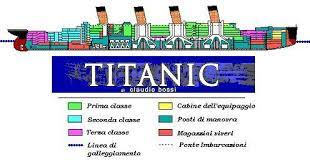

C'è da tener conto anche di come è affondata la nave: è andata giù prima di prua, poi si è spezzata a metà e la prua è affondata definitivamente, seguita poco dopo dalla poppa.

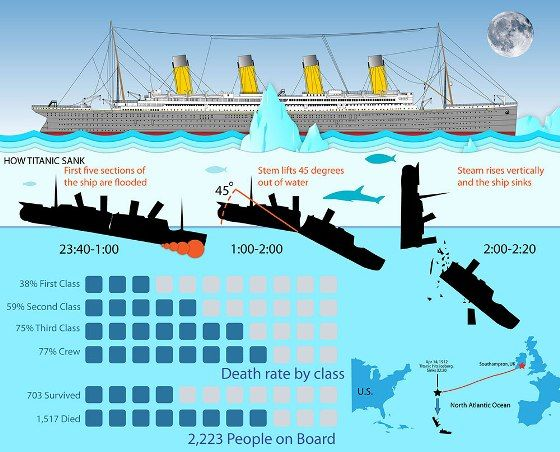

In [242]:
# la funzione get_dummies è stata utilizzata per separare i tre valori presenti nella colonna "Pclass" in un nuovo DataFrame
classes = pd.get_dummies(train["Pclass"])
classes.rename(columns={1: "First", 2: "Second", 3: "Third"}, inplace = True)

firstClass = train.loc[classes.First == 1]["Survived"]
print(f"First class survival rate: {(sum(firstClass)/len(firstClass))*100}%")

secondClass = train.loc[classes.Second == 1]["Survived"]
print(f"Second class survival rate: {(sum(secondClass)/len(secondClass))*100}%")

thirdClass = train.loc[classes.Third == 1]["Survived"]
print(f"Third class survival rate: {(sum(thirdClass)/len(thirdClass))*100}%")

First class survival rate: 62.96296296296296%
Second class survival rate: 47.28260869565217%
Third class survival rate: 24.236252545824847%


L'ultima analisi effettuata riguarda l'età. Abbiamo deciso di suddividere tutte le età presenti nella colonna in diverse categorie di appartenenza, in modo da aggregare i dati più o meno simili.

Abbiamo scelto la seguente suddivisione in categorie:

In [243]:
train.loc[train['Age'] <= 12, 'Age'] = 0                           # junior
train.loc[(train['Age'] > 12) & (train['Age'] <= 19), 'Age'] = 1   # teen
train.loc[(train['Age'] > 19) & (train['Age'] <= 30), 'Age'] = 2   # guy
train.loc[(train['Age'] > 30) & (train['Age'] <= 40), 'Age'] = 3   # adult1
train.loc[(train['Age'] > 40) & (train['Age'] <= 50), 'Age'] = 4   # adult2
train.loc[(train['Age'] > 50) & (train['Age'] <= 60), 'Age'] = 5   # adult3
train.loc[train['Age'] > 60, 'Age'] = 6   # senior

# test.loc[train['Age'] <= 12, 'Age'] = 0                           # junior
# test.loc[(train['Age'] > 12) & (test['Age'] <= 19), 'Age'] = 1   # teen
# test.loc[(train['Age'] > 19) & (test['Age'] <= 30), 'Age'] = 2   # guy
# test.loc[(train['Age'] > 30) & (test['Age'] <= 40), 'Age'] = 3   # adult1
# test.loc[(train['Age'] > 40) & (test['Age'] <= 50), 'Age'] = 4   # adult2
# test.loc[(train['Age'] > 50) & (test['Age'] <= 60), 'Age'] = 5   # adult3
# test.loc[train['Age'] > 60, 'Age'] = 6   # senior

Dall'analisi sulle età, quindi, è emerso che la percentuale di sopravvivenza è maggiore nella fascia d'età tra i 0 e i 12 anni, ma è da tenere presente che ci sono anche molte meno persone rispetto alle fasce d'età tra i 20 e i 30 anni e tra i 31 e i 40 anni.

In [244]:
junior = train.loc[train.Age == 0]["Survived"]
print(f"0-12 yo survival rate: {(sum(junior)/len(junior))*100}% ({len(junior)})")

teen = train.loc[train.Age == 1]["Survived"]
print(f"13-19 yo survival rate: {(sum(teen)/len(teen))*100}% ({len(teen)})")

guy = train.loc[train.Age == 2]["Survived"]
print(f"20-30 yo survival rate: {(sum(guy)/len(guy))*100}% ({len(guy)})")

adult1 = train.loc[train.Age == 3]["Survived"]
print(f"31-40 yo survival rate: {(sum(adult1)/len(adult1))*100}% ({len(adult1)})")

adult2 = train.loc[train.Age == 4]["Survived"]
print(f"41-50 yo survival rate: {(sum(adult2)/len(adult2))*100}% ({len(adult2)})")

adult3 = train.loc[train.Age == 5]["Survived"]
print(f"51-60 yo survival rate: {(sum(adult3)/len(adult3))*100}% ({len(adult3)})")

senior = train.loc[train.Age == 6]["Survived"]
print(f"61+ yo survival rate: {(sum(senior)/len(senior))*100}% ({len(senior)})")

0-12 yo survival rate: 57.971014492753625% (69)
13-19 yo survival rate: 41.05263157894737% (95)
20-30 yo survival rate: 32.78301886792453% (424)
31-40 yo survival rate: 44.516129032258064% (155)
41-50 yo survival rate: 39.285714285714285% (84)
51-60 yo survival rate: 40.476190476190474% (42)
61+ yo survival rate: 22.727272727272727% (22)


Ci siamo resi conto che questi risultati, presi singolarmente non ci avrebbero portato ad una soluzione completa. Abbiamo quindi deciso di combinare le varie condizioni e analizzare nuovamente i dati come segue:
- donne in prima classe, suddivise per fasce d'età

In [245]:
femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 0) & (classes.First == 1)]["Survived"]
print(f"0-12 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 1) & (classes.First == 1)]["Survived"]
print(f"13-19 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 2) & (classes.First == 1)]["Survived"]
print(f"20-30 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 3) & (classes.First == 1)]["Survived"]
print(f"31-40 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 4) & (classes.First == 1)]["Survived"]
print(f"41-50 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 5) & (classes.First == 1)]["Survived"]
print(f"51-60 yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 6) & (classes.First == 1)]["Survived"]
print(f"61+ yo female survival rate in first class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

0-12 yo female survival rate in first class: 0.0% (1)
13-19 yo female survival rate in first class: 100.0% (13)
20-30 yo female survival rate in first class: 96.66666666666667% (30)
31-40 yo female survival rate in first class: 100.0% (24)
41-50 yo female survival rate in first class: 92.3076923076923% (13)
51-60 yo female survival rate in first class: 100.0% (11)
61+ yo female survival rate in first class: 100.0% (2)


- donne in seconda classe, suddivise per fasce d'età

In [246]:
femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 0) & (classes.Second == 1)]["Survived"]
print(f"0-12 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 1) & (classes.Second == 1)]["Survived"]
print(f"13-19 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 2) & (classes.Second == 1)]["Survived"]
print(f"20-30 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 3) & (classes.Second == 1)]["Survived"]
print(f"31-40 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 4) & (classes.Second == 1)]["Survived"]
print(f"41-50 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 5) & (classes.Second == 1)]["Survived"]
print(f"51-60 yo female survival rate in second class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

# é stato appurato tramite errori che, in questa fascia d'età, non è sopravvissuta alcuna donna'
# femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 6) & (classes.Second == 1)]["Survived"]
# print(f"prova: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% {len(femaleAgePclass)}") ERROR: DIVISION BY ZERO
print("61+ yo female survival rate in second class: 0.0% (0)")

0-12 yo female survival rate in second class: 100.0% (8)
13-19 yo female survival rate in second class: 100.0% (8)
20-30 yo female survival rate in second class: 90.0% (30)
31-40 yo female survival rate in second class: 94.11764705882352% (17)
41-50 yo female survival rate in second class: 90.0% (10)
51-60 yo female survival rate in second class: 66.66666666666666% (3)
61+ yo female survival rate in second class: 0.0% (0)


- donne in terza classe, suddivise per fasce d'età

In [247]:
femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 0) & (classes.Third == 1)]["Survived"]
print(f"0-12 yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 1) & (classes.Third == 1)]["Survived"]
print(f"13-19 yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 2) & (classes.Third == 1)]["Survived"]
print(f"20-30 yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 3) & (classes.Third == 1)]["Survived"]
print(f"31-40 yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 4) & (classes.Third == 1)]["Survived"]
print(f"41-50 yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

# é stato appurato tramite errori che, in questa fascia d'età, non è sopravvissuta alcuna donna'
# femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 5) & (classes.Third == 1)]["Survived"
# print(f"prova: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% {len(femaleAgePclass)}")
print("51-60 yo female survival rate in third class: 0.0% (0)")

femaleAgePclass = train.loc[(train.Sex == 1) & (train.Age == 6) & (classes.Third == 1)]["Survived"]
print(f"61+ yo female survival rate in third class: {(sum(femaleAgePclass)/len(femaleAgePclass))*100}% ({len(femaleAgePclass)})")

0-12 yo female survival rate in third class: 47.82608695652174% (23)
13-19 yo female survival rate in third class: 59.09090909090909% (22)
20-30 yo female survival rate in third class: 53.246753246753244% (77)
31-40 yo female survival rate in third class: 46.15384615384615% (13)
41-50 yo female survival rate in third class: 0.0% (8)
51-60 yo female survival rate in third class: 0.0% (0)
61+ yo female survival rate in third class: 100.0% (1)


- uomini in prima classe, suddivisi per fasce d'età

In [248]:
maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 0) & (classes.First == 1)]["Survived"]
print(f"0-12 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 1) & (classes.First == 1)]["Survived"]
print(f"13-19 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 2) & (classes.First == 1)]["Survived"]
print(f"20-30 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 3) & (classes.First == 1)]["Survived"]
print(f"31-40 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 4) & (classes.First == 1)]["Survived"]
print(f"41-50 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 5) & (classes.First == 1)]["Survived"]
print(f"51-60 yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 6) & (classes.First == 1)]["Survived"]
print(f"61+ yo male survival rate in first class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

0-12 yo male survival rate in first class: 100.0% (3)
13-19 yo male survival rate in first class: 25.0% (4)
20-30 yo male survival rate in first class: 35.0% (40)
31-40 yo male survival rate in first class: 52.0% (25)
41-50 yo male survival rate in first class: 37.5% (24)
51-60 yo male survival rate in first class: 28.57142857142857% (14)
61+ yo male survival rate in first class: 8.333333333333332% (12)


- uomini in seconda classe, suddivisi per fasce d'età

In [249]:
maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 0) & (classes.Second == 1)]["Survived"]
print(f"0-12 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 1) & (classes.Second == 1)]["Survived"]
print(f"13-19 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 2) & (classes.Second == 1)]["Survived"]
print(f"20-30 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 3) & (classes.Second == 1)]["Survived"]
print(f"31-40 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 4) & (classes.Second == 1)]["Survived"]
print(f"41-50 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 5) & (classes.Second == 1)]["Survived"]
print(f"51-60 yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 6) & (classes.Second == 1)]["Survived"]
print(f"61+ yo male survival rate in second class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

0-12 yo male survival rate in second class: 100.0% (9)
13-19 yo male survival rate in second class: 10.0% (10)
20-30 yo male survival rate in second class: 4.761904761904762% (42)
31-40 yo male survival rate in second class: 11.538461538461538% (26)
41-50 yo male survival rate in second class: 11.11111111111111% (9)
51-60 yo male survival rate in second class: 0.0% (9)
61+ yo male survival rate in second class: 33.33333333333333% (3)


- uomini in terza classe, suddivisi per fasce d'età

In [250]:
maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 0) & (classes.Third == 1)]["Survived"]
print(f"0-12 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 1) & (classes.Third == 1)]["Survived"]
print(f"13-19 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 2) & (classes.Third == 1)]["Survived"]
print(f"20-30 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 3) & (classes.Third == 1)]["Survived"]
print(f"31-40 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 4) & (classes.Third == 1)]["Survived"]
print(f"41-50 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 5) & (classes.Third == 1)]["Survived"]
print(f"51-60 yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

maleAgePclass = train.loc[(train.Sex == 0) & (train.Age == 6) & (classes.Third == 1)]["Survived"]
print(f"61+ yo male survival rate in third class: {(sum(maleAgePclass)/len(maleAgePclass))*100}% ({len(maleAgePclass)})")

0-12 yo male survival rate in third class: 36.0% (25)
13-19 yo male survival rate in third class: 7.894736842105263% (38)
20-30 yo male survival rate in third class: 12.682926829268293% (205)
31-40 yo male survival rate in third class: 14.000000000000002% (50)
41-50 yo male survival rate in third class: 10.0% (20)
51-60 yo male survival rate in third class: 0.0% (5)
61+ yo male survival rate in third class: 0.0% (4)


_______________________________________________________________________________________________________________________________
Abbiamo deciso di rappresentare graficamente anche la correlazione tra le varie colonne del DataFrame, utilizzando la libreria "seaborn".

Il metodo corr() produce la matrice di correlazione dei dati numerici di un DataFrame, che viene visualizzata graficamente in una heatmap. Il grafico si legge nel seguente modo:
- più una cella è vicina al rosso (e quindi al valore 1) e più sarà forte la correlazione diretta tra i membri che la formano;
- più è vicina al blu (e quindi al valore -1) e più sarà forte la correlazione inversa tra i membri che la formano;
- più è vicina al bianco (cioè allo 0) e meno c'è correlazione.

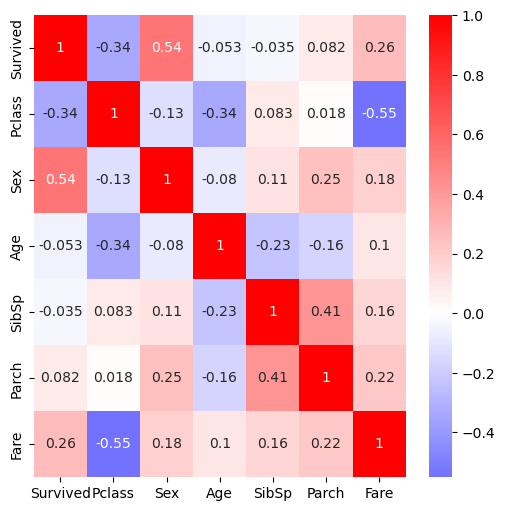

In [251]:
fig, ax = plt.subplots(figsize=(6,6))  # questo serve solo a ingrandire la heatmap e renderla leggibile

# https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/
sb.heatmap(train.corr(), cmap = 'bwr', annot=True, center=0, ax=ax)
plt.show()  # mostra la heatmap

A noi interessa la correlazione tra la colonna "Survived" e tutte le altre, quindi possiamo prendere in esame solo la prima colonna.
Osserviamo che:
- la correlazione tra "Survived" e se stesso è (ovviamente) 1;
- c'è correlazione positiva tra "Sex" e "Survived". Ricordando che se un passeggero è sopravvissuto il valore è 1 mentre se è morto è 0, e che il sesso è stato reso come f=1 e m=0, in linea con le osservazioni precedenti si evince che i passeggeri di sesso femminile hanno maggiore probabilità di sopravvivenza;
- la classe del biglietto ("Pclass") è inversamente correlata, quindi una classe con un valore più basso (che indica i passeggeri più abbienti) ha più probabilità di salvarsi;
- "Age" e "SibSp" sono inversamente correlati, quindi l'anzianità e la presenza di coniugi/fratelli/sorelle a bordo influiscono negativamente con le chance di sopravvivenza;
- "Parch" ha una correlazione positiva, quindi un passeggero accompagnato da un genitore (o inversamente dai figli) ha più chance di salvarsi;
- la spesa a bordo ("Fare") ha una correlazione positiva;
- il porto di imbarco ("Embarked") ha una correlazione debole, con Cherbourg che offre una leggera probabilità di sopravvivenza, Southampton una leggera probabilità di morte, e Queenstown praticamente ininfluente.

_______________________________________________________________________________________________________________________________
Per quanto riguarda l'algoritmo da utilizzare per addestrare la macchina, abbiamo scelto il Random Forest piuttosto che il Decision Tree in quanto è un modello di classificazione che sfrutta numerosi alberi decisionali per ottenere un risultato complessivo migliore e più preciso.

In [252]:
X = train.drop("Survived", axis=1)
Y = train["Survived"]

# implementing train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

In [258]:
# random_state -> Using an int will produce the same results across different calls
# max_features -> The number of features to consider when looking for the best split

# random forest model creation
random_forest = rfc(random_state = 0, n_estimators = 100, max_features = None) # takes all the features
random_forest.fit(X_train, Y_train)
# predictions
Y_predict = random_forest.predict(X_test)
accuracy = accuracy_score(Y_test, Y_predict)

In [259]:
print(f"L'accurancy per il file \"train.csv\" è del {round(accuracy * 100, 2)}%")

L'accurancy per il file "train.csv" è del 83.73%


In [260]:
print(Y_predict)

[0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0
 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1]
